# This Notebook is an example of using pcap pandas analytics to build a temporal graph from Newt orchestration of Hamlet by Scenes

In [1]:
import IPython
import matplotlib
from distutils.version import StrictVersion
ipy4 = False
violin = False
if StrictVersion(IPython.__version__) >= StrictVersion("4.0"):
    ipy4 = True
if StrictVersion(matplotlib.__version__) >= StrictVersion("1.5"):
    violin = True
    
import log2pd as lpd
#import plotpd as ppd
import pandas as pd
import log2plot as l2plot
import analystPlots as appd
import logAnalyticsLib as lalib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import numpy as np
import os
import warnings
from netaddr import IPNetwork
import glob
from StringIO import StringIO
import fileinput
from pandas.lib import Timestamp
import datetime
import subprocess
#from IPython.display import Image
#os.system("taskset -p 0xFFFFFFFF %d" % os.getpid())
# Setup some plot defaults for the duration of this notebook
#ppd.setup_plot_defaults()
warnings.filterwarnings("ignore")
root_dir = '.'
%matplotlib inline

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
#df = lalib.load_hdf5('./store-mgen-mcast-ham.hdf5')  
from scipy.interpolate import interp1d
from operator import itemgetter

In [3]:
import json

In [4]:
json_data=open("./data/core_actor_mapping.json").read()
d = json.loads(json_data)
print d

{u'Gertrude': {u'node': u'n12', u'address': u'10.0.0.12'}, u'Laertes': {u'node': u'n17', u'address': u'10.0.0.17'}, u'Gentleman': {u'node': u'n11', u'address': u'10.0.0.11'}, u'Player1': {u'node': u'n24', u'address': u'10.0.0.24'}, u'Messenger': {u'node': u'n21', u'address': u'10.0.0.21'}, u'Clown2': {u'node': u'n6', u'address': u'10.0.0.6'}, u'Clown1': {u'node': u'n5', u'address': u'10.0.0.5'}, u'Lord': {u'node': u'n18', u'address': u'10.0.0.18'}, u'Marcellus': {u'node': u'n20', u'address': u'10.0.0.20'}, u'Francisco': {u'node': u'n10', u'address': u'10.0.0.10'}, u'Bernardo': {u'node': u'n2', u'address': u'10.0.0.2'}, u'Ophelia': {u'node': u'n22', u'address': u'10.0.0.22'}, u'Voltimand': {u'node': u'n34', u'address': u'10.0.0.34'}, u'Polonius': {u'node': u'n27', u'address': u'10.0.0.27'}, u'Ghost': {u'node': u'n13', u'address': u'10.0.0.13'}, u'Horatio': {u'node': u'n16', u'address': u'10.0.0.16'}, u'Servant': {u'node': u'n33', u'address': u'10.0.0.33'}, u'Fortinbras': {u'node': u'n9'

In [5]:
# Read the node file and create a dict of ip address to CORE nodename
n_to_a_dict={}
for actor,value in d.iteritems():
    n_to_a_dict[value['address']]=value['node']
print n_to_a_dict
#n_to_a_dict['224.0.5.2']='n50'
#
# Use CORE names for graph nodes

import networkx as nx
G=nx.DiGraph()
nodes = n_to_a_dict.values()
G.add_nodes_from(nodes)
n_weights={node:0 for node in nodes}
print n_weights
nx.set_node_attributes(G,'weight',n_weights)
print G.nodes(data=True)

{u'10.0.0.33': u'n33', u'10.0.0.32': u'n32', u'10.0.0.31': u'n31', u'10.0.0.30': u'n30', u'10.0.0.34': u'n34', u'10.0.0.15': u'n15', u'10.0.0.14': u'n14', u'10.0.0.17': u'n17', u'10.0.0.16': u'n16', u'10.0.0.11': u'n11', u'10.0.0.10': u'n10', u'10.0.0.13': u'n13', u'10.0.0.12': u'n12', u'10.0.0.19': u'n19', u'10.0.0.18': u'n18', u'10.0.0.9': u'n9', u'10.0.0.8': u'n8', u'10.0.0.5': u'n5', u'10.0.0.4': u'n4', u'10.0.0.7': u'n7', u'10.0.0.6': u'n6', u'10.0.0.1': u'n1', u'10.0.0.3': u'n3', u'10.0.0.2': u'n2', u'10.0.0.28': u'n28', u'10.0.0.29': u'n29', u'10.0.0.24': u'n24', u'10.0.0.25': u'n25', u'10.0.0.26': u'n26', u'10.0.0.27': u'n27', u'10.0.0.20': u'n20', u'10.0.0.21': u'n21', u'10.0.0.22': u'n22', u'10.0.0.23': u'n23'}
{u'n12': 0, u'n13': 0, u'n10': 0, u'n11': 0, u'n16': 0, u'n17': 0, u'n14': 0, u'n15': 0, u'n18': 0, u'n19': 0, u'n30': 0, u'n31': 0, u'n32': 0, u'n33': 0, u'n34': 0, u'n29': 0, u'n28': 0, u'n23': 0, u'n22': 0, u'n21': 0, u'n20': 0, u'n27': 0, u'n26': 0, u'n25': 0, u'n2

In [6]:
node_to_actor={}
addr_to_actor={}
for actor,value in d.iteritems():
    node_to_actor[value['node']]=actor
    addr_to_actor[value['address']]=actor


In [7]:
Scenes=['Collect_ActISceneI',
       'Collect_ActISceneII',
       'Collect_ActISceneIII',
       'Collect_ActISceneIV',
       'Collect_ActISceneV',
       'Collect_ActIISceneI',
       'Collect_ActIISceneII',
       'Collect_ActIIISceneI',
       'Collect_ActIIISceneII',
       'Collect_ActIIISceneIII',
       'Collect_ActIIISceneIV',
       'Collect_ActIVSceneI',
       'Collect_ActIVSceneII',
       'Collect_ActIVSceneIII',
       'Collect_ActIVSceneIV',
       'Collect_ActIVSceneV',
       'Collect_ActIVSceneVI',
       'Collect_ActIVSceneVII',
       'Collect_ActVSceneI',
       'Collect_ActVSceneII',
       ]

In [8]:
def make_hamlet_hdf5(dataset=""):    
    #Must first run newt based hamlet.sh to get DataCollect directory
    result='./results/'+dataset
    scenepd=lpd.load_pcap_data(result,
                               duplicates=True,
                               timeseries=True,
                               dataSet=True)
    sorteddf=scenepd.set_index('time')
    sorteddf=sorteddf.sort_index()
    sorteddf=sorteddf[(sorteddf["frameType"]=="UDP") & (sorteddf["dir"]==2)]
    return sorteddf

In [9]:
def get_temp_graph(G,dataset=""):    
    #Must first run newt based hamlet.sh to get DataCollect directory
    H=G.copy()
    result='./results/'+dataset
    scenepd=lpd.load_pcap_data(result,
                               duplicates=True,
                               timeseries=True,
                               dataSet=True)
    sorteddf=scenepd.set_index('time')
    sorteddf=sorteddf.sort_index()
    sorteddf=sorteddf[(sorteddf["frameType"]=="UDP") & (sorteddf["dir"]==2)]
    ###### Build and estimated  CAG from adjacencies
    last_speaker=None
    # Build a graph from multicast packets received
    # Use ipSrc information to create pair-wise adjacencies
    for index,row in sorteddf.iterrows():
        if last_speaker == row.ipSrc:
            pass
        else:
# I am already filtering out only receive events so above is not necessary
            H.node[n_to_a_dict[row.ipSrc]]["weight"] += 1
            if H.has_edge(n_to_a_dict[row.ipSrc],n_to_a_dict[row.ipDst]):
                H[n_to_a_dict[row.ipSrc]][n_to_a_dict[row.ipDst]]['weight'] += 1
            else:
                H.add_edge(n_to_a_dict[row.ipSrc],n_to_a_dict[row.ipDst],weight= 1)
            last_speaker= row.ipSrc
        if last_speaker == None:
            last_speaker = row.ipSrc
    H=nx.relabel_nodes(H,node_to_actor)
# add cost on edges as well
    for u,v,data in H.edges_iter(data=True):
        w=data['weight']
        if w > 0.0 :
            H[u][v]['cost']=1./w
    return H,sorteddf

In [10]:
#tempg,sorteddf=get_temp_graph(G,dataset="Collect_ActISceneII/")

In [11]:
#print nx.get_node_attributes(tempg,"weight")
#print nx.get_edge_attributes(tempg,"weight")
#print sorteddf[sorteddf["ipSrc"]=="10.0.0.15"][['ipSrc','ipDst','nodeName','dir','len']]
#print len(sorteddf[sorteddf["ipSrc"]=="10.0.0.15"][['ipSrc','ipDst','nodeName','dir','len']])

In [12]:
scene_graphs=[]
aggr_df=pd.DataFrame()
import os.path
import pickle
if os.path.isfile("foobar.p"):
    scene_graphs=pickle.load( open( "scene_graphs.p", "rb" ))
else:
    for scene in Scenes:
        print ""
        print "working on :" + scene
        tempg,sorteddf = get_temp_graph(G,dataset=scene)
        print "completed graph for :" + scene
        scene_graphs.append((scene,tempg))
        print scene
        tempdict=nx.get_node_attributes(tempg,'weight')
        for key, value in tempdict.iteritems():
            if value > 0:
    #            pass
                print key,value

    pickle.dump(scene_graphs, open( "scene_graphs.p", "wb" ))


working on :Collect_ActISceneI
completed graph for :Collect_ActISceneI
Collect_ActISceneI
Marcellus 16
Francisco 8
Bernardo 19
Horatio 16

working on :Collect_ActISceneII
completed graph for :Collect_ActISceneII
Collect_ActISceneII
Gertrude 3
Laertes 1
Marcellus 7
Bernardo 1
Polonius 1
Horatio 25
Claudius 7
Cornelius 1
Hamlet 32

working on :Collect_ActISceneIII
completed graph for :Collect_ActISceneIII
Collect_ActISceneIII
Laertes 7
Ophelia 9
Polonius 8

working on :Collect_ActISceneIV
completed graph for :Collect_ActISceneIV
Collect_ActISceneIV
Marcellus 5
Horatio 13
Hamlet 10

working on :Collect_ActISceneV
completed graph for :Collect_ActISceneV
Collect_ActISceneV
Marcellus 6
Ghost 13
Horatio 14
Hamlet 28

working on :Collect_ActIISceneI
completed graph for :Collect_ActIISceneI
Collect_ActIISceneI
Ophelia 5
Polonius 18
Reynaldo 13

working on :Collect_ActIISceneII
completed graph for :Collect_ActIISceneII
Collect_ActIISceneII
Gertrude 9
Player1 6
Voltimand 1
Polonius 40
Claudius 1

In [11]:
def plot_hamlet(G,maxsize=1000,alpha=0.3,title="",
                font_size=14,plot_type=1,maxedge=10,pos=None,directed=True):
    fig = plt.Figure(figsize=(15,15))
    if not directed:
        G=G.to_undirected()
    if plot_type == 1:
        node_weights = nx.get_node_attributes(G,"weight")
        edge_weights = nx.get_edge_attributes(G,"weight")
        if title == "":
            title = "Hamlet Graph: Nodes Dialogue Events, Edges Causality Events"
        else:
            title = title
    else:        
        node_weights = nx.in_degree_centrality(G)
        edge_weights = nx.edge_betweenness_centrality(G,weight="cost",normalized=True)
        title = "Hamlet Graph: Nodes Current Centrality, Edges Betweenness Centrality"
    ncolors=[]
    # Dictionaries are not ordered properly so make sure it ordered with nodes
    for node in G.nodes():
        ncolors.append(node_weights[node])
    ecolors=[]
    for edge in G.edges():
        ecolors.append(edge_weights[edge])
    mn = interp1d([0,1],[100,maxsize])
    me = interp1d([0,1],[1,maxedge])
#    dn = interp1d([min(ncolors),max(ncolors)],[0,1]) 
#    de = interp1d([min(ecolors),max(ecolors)],[0,1])
    dn = interp1d([0,max(ncolors)],[0,1]) 
    de = interp1d([0,max(ecolors)],[0,1])
    ncolors = dn(ncolors) 
    nsizes =  mn(ncolors)
    ecolors = de(ecolors) 
    esizes =  me(ecolors)
    plt.axis('off')
    plt.title(title, size=font_size)

    if pos is None:
        pos=nx.spring_layout(G,k=1,iterations=100,weight='weight')
    else:
        pos=pos
    nx.draw_networkx_nodes(G,pos,node_color=ncolors,\
                           node_size=nsizes,alpha=alpha,cmap=plt.cm.jet)
    nx.draw_networkx_labels(G,pos,font_size=font_size,cmap=plt.cm.jet)
    nx.draw_networkx_edges(G,pos,edge_color=ecolors,\
                           width=esizes,alpha=alpha,cmap=plt.cm.jet)

In [12]:
Scenes=['Act1:Sc1',
       'Act1:Sc2',
       'Act1:Sc3',
       'Act1:Sc4',
       'Act1:Sc5',
       'Act2:Sc1',
       'Act2:Sc2',
       'Act3:Sc1',
       'Act3:Sc2',
       'Act3:Sc3',
       'Act3:Sc4',
       'Act4:Sc1',
       'Act4:Sc2',
       'Act4:Sc3',
       'Act4:Sc4',
       'Act4:Sc5',
       'Act4:Sc6',
       'Act4:Sc7',
       'Act5:Sc1',
       'Act5:Sc2']
def plot_scene_graphs(ordered_graph_list):
    rows = 4
    cols = 5
    smax = 9
    plt.figure(figsize=(12,12))
    for i in range(len(ordered_graph_list)):
        tempG = ordered_graph_list[i].copy()
#        UG = ordered_graph_list[i].to_undirected()
#        u_ordered_graph_list.append(UG)
        deg = tempG.degree()
        to_remove = [n for n in deg if deg[n] == 0]
        tempG.remove_nodes_from(to_remove)
        row = int(i/cols)
        col = i%cols
        num = i%smax+1
        place = str(rows)+str(cols)+str(num)
        t=Scenes[i]
        plt.subplot2grid((4,5),(int(row), int(col)))
        plot_hamlet(tempG,maxsize=300,alpha=0.5,maxedge=1,
                    font_size=12,plot_type=1,title=t,directed=False)
    plt.show()
    return

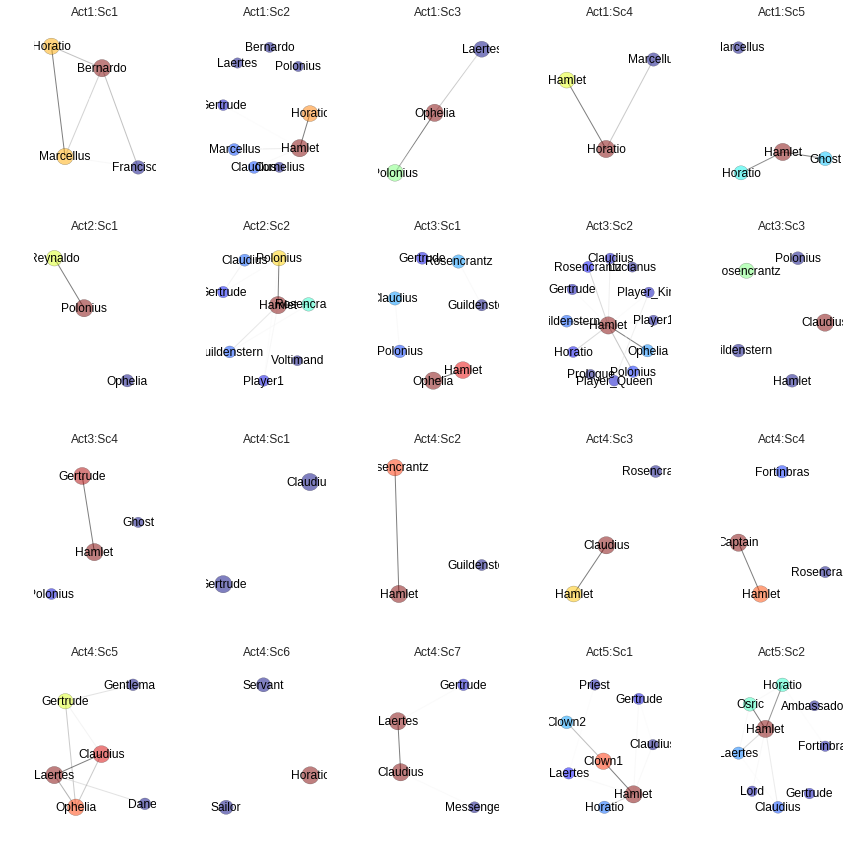

In [16]:
ordered_graphs=[graph for gname,graph in scene_graphs]
plot_scene_graphs(ordered_graphs)

In [21]:
def plot_anal_graph(G,maxsize=1000,alpha=0.3,font_size=14,
                    plot_type=1,maxedge=1,pos=None):
    from scipy.interpolate import interp1d
    if plot_type == 1:
        node_weights = nx.get_node_attributes(G,"weight")
        edge_weights = nx.get_edge_attributes(G,"weight")
        title = "Nodes Dialogue Events, Edges Causality Events"
    else:        
        node_weights = nx.in_degree_centrality(G)
        edge_weights = nx.edge_betweenness_centrality(G,weight="cost",normalized=True)
        title = "Nodes Current Centrality, Edges Betweenness Centrality"
    ncolors=[]
    # Dictionaries are not ordered properly so make sure it ordered with nodes
    for node in G.nodes():
        ncolors.append(node_weights[node])
    ecolors=[]
    for edge in G.edges():
        ecolors.append(edge_weights[edge])

    mn = interp1d([0,1],[100,maxsize])
    me = interp1d([0,1],[1,maxedge])
    dn = interp1d([min(ncolors),max(ncolors)],[0,1]) 
    de = interp1d([min(ecolors),max(ecolors)],[0,1])
    ncolors = dn(ncolors) 
    nsizes =  mn(ncolors)
    ecolors = de(ecolors) 
    esizes =  me(ecolors)

    plt.axis('off')
    plt.title(title, size=24)
    if pos is None:
        pos=nx.spring_layout(G,k=1,iterations=100,weight='weight')
    else:
        pos=pos
    nx.draw_networkx_nodes(G,pos,node_color=ncolors,\
                           node_size=nsizes,alpha=alpha,cmap=cmx.jet)
    nx.draw_networkx_labels(G,pos,font_size=font_size)
    nx.draw_networkx_edges(G,pos,edge_color=ecolors,\
                           width=esizes,alpha=alpha)

In [22]:
print len(scene_graphs)

20


In [25]:

#let me make an aggregate graph
#I need to sum attribute values
agroG=nx.DiGraph()
first=True
for scene,sgraph in scene_graphs:
    if first:
        agroG= sgraph.copy()
        first=False
    else:
        # add up node weights (conversation events) across all graphs
        for nodename in sgraph.nodes():
            agroG.node[nodename]['weight']=agroG.node[nodename]['weight']+sgraph.node[nodename]['weight']
        for edge in sgraph.edges(data=True):
            if (edge[0],edge[1]) in agroG.edges():
                agroG.edge[edge[0]][edge[1]]['weight']=\
                agroG.edge[edge[0]][edge[1]]['weight']+\
                sgraph.edge[edge[0]][edge[1]]['weight']
            else:
                agroG.add_edge(edge[0],edge[1],weight=edge[2]['weight'])
#    print G.nodes(data=True)        

In [26]:
def plot_ordered_items(dict_weights, title=None):
    order_items = sorted(dict_weights.iteritems(), key=itemgetter(1), reverse=True)
    #reverse zip tuples in to separate lists
    order_items = zip(*order_items)
    my_xticks = order_items[0]
    x = [i for i in range(0,len(my_xticks))]
    offset = [i+0.5 for i in x]
    fig = plt.Figure(figsize=(20,14))
    plt.xticks(offset, my_xticks,rotation=90)
    plt.bar(x,order_items[1],alpha=0.3)
    if title != None:
        plt.title(title)
    plt.show()

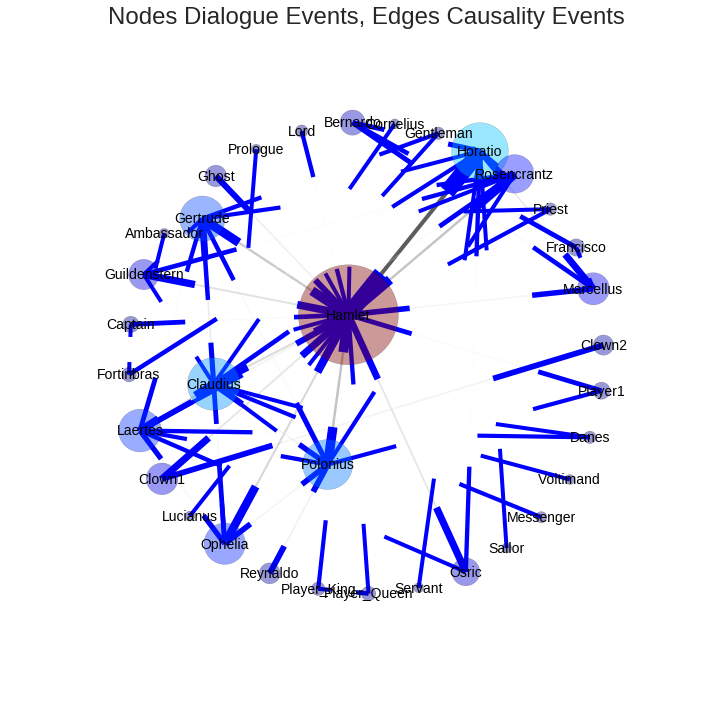

In [27]:
G=agroG
G=nx.relabel_nodes(G,node_to_actor)
Figure=plt.figure(figsize=(10,10))
pos=nx.spring_layout(G,k=1,iterations=100,weight='weight')
plot_anal_graph(G,maxsize=10000,maxedge=4,alpha=0.4,pos=pos)

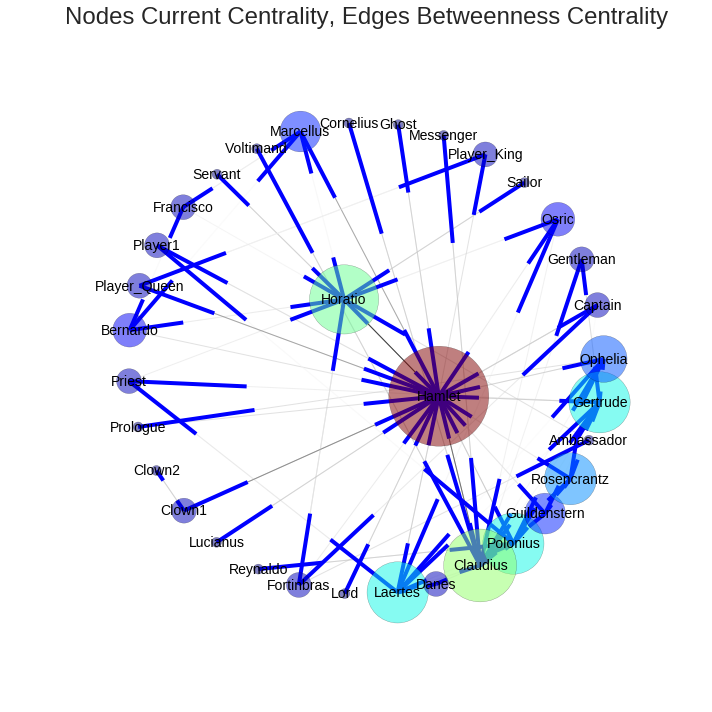

In [28]:
pos=nx.spring_layout(G,k=1,iterations=1000)
Figure = plt.figure(figsize=(10,10))
plot_anal_graph(G,maxsize=10000,maxedge=1,plot_type=2,alpha=0.5,pos=pos)

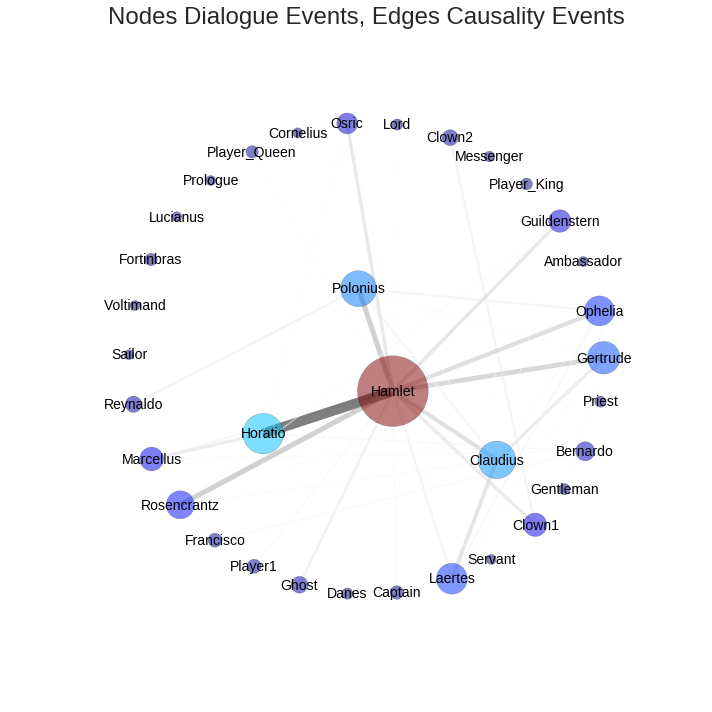

In [29]:
Gu=G.to_undirected(reciprocal=True)
Figure = plt.figure(figsize=(10,10))
pos=nx.spring_layout(Gu,k=1,iterations=100)
plot_anal_graph(Gu,maxsize=5000,maxedge=10,alpha=0.5,pos=pos)

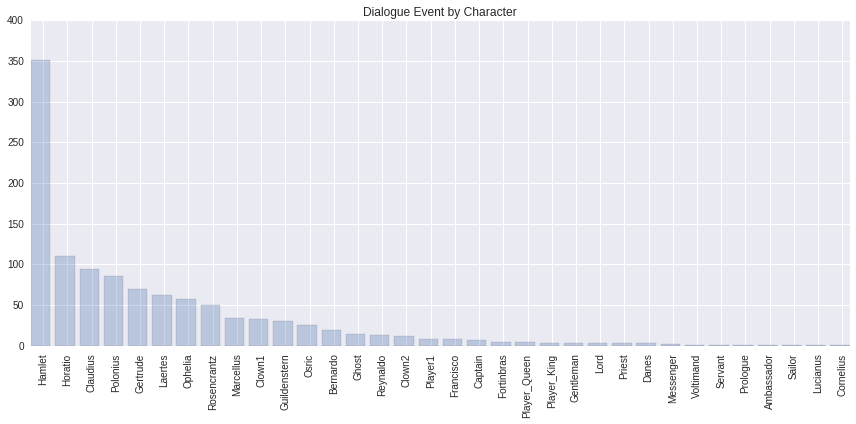

In [30]:
Figure = plt.figure(figsize=(12,6))
node_weights = nx.get_node_attributes(G,"weight")
plot_ordered_items(node_weights,title="Dialogue Event by Character")

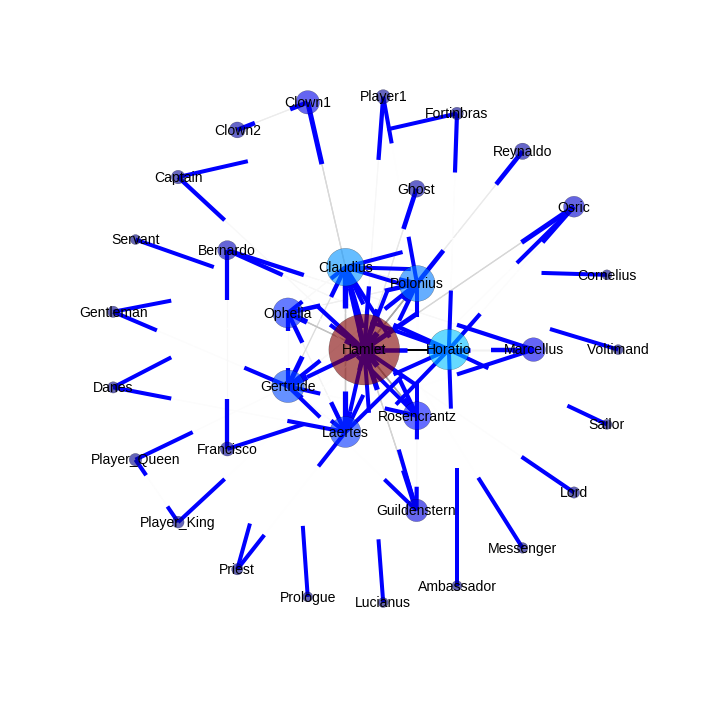

In [31]:
Gu=G
Figure = plt.figure(figsize=(10,10))
# Experiment with a Ring Layout of Actors in graphs
ring1 = ['Hamlet']
ring2 = ['Horatio','Polonius','Claudius','Ophelia','Gertrude','Laertes','Rosencrantz']
ring3 = ['Marcellus','Ghost','Bernardo','Francisco','Guildenstern']
outer = ['Voltimand','Cornelius','Osric','Reynaldo','Fortinbras',\
        'Player1','Clown1','Clown2','Captain','Servant','Gentleman',\
         'Danes','Player_Queen','Player_King','Priest','Prologue',\
         'Lucianus','Ambassador','Messenger','Lord','Sailor']
maxsize=5000
maxedge=2
node_weights = nx.get_node_attributes(Gu,"weight")
edge_weights = nx.get_edge_attributes(Gu,"weight")
ncolors=[]
    # Dictionaries are not ordered properly so make sure it ordered with nodes
for node in Gu.nodes():
    ncolors.append(node_weights[node])
ecolors=[]
for edge in Gu.edges():
    ecolors.append(edge_weights[edge])

mn = interp1d([0,1],[100,maxsize])
me = interp1d([0,1],[1,maxedge])
dn = interp1d([min(ncolors),max(ncolors)],[0,1]) 
de = interp1d([min(ecolors),max(ecolors)],[0,1])
ncolors = dn(ncolors) 
nsizes =  mn(ncolors)
ecolors = de(ecolors) 
esizes =  me(ecolors)
nlist = [ring1,ring2,ring3,outer]
plt.axis('off')

pos=nx.shell_layout(Gu, nlist=nlist, dim=3, scale=5)
nx.draw_networkx_nodes(Gu,pos,node_color=ncolors,\
                       node_size=nsizes,alpha=0.6,cmap=plt.cm.jet)
nx.draw_networkx_labels(Gu,pos,font_size=14,cmap=plt.cm.jet)
nx.draw_networkx_edges(Gu,pos,edge_color=ecolors,\
                       width=esizes,alpha=1.0,cmap=plt.cm.jet)

(0, 12)

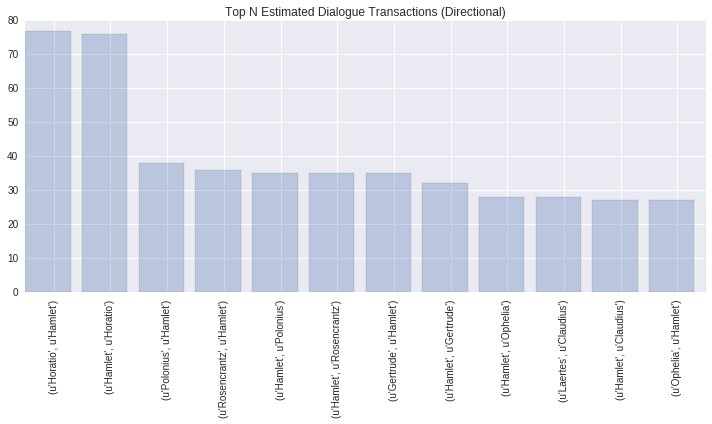

In [32]:
Figure = plt.figure(figsize=(10,6))
edge_weights = nx.get_edge_attributes(G,"weight")
order_edges = sorted(edge_weights.iteritems(), key=itemgetter(1), reverse=True)
#reverse zip tuples in to separate lists
order_edges = zip(*order_edges)
my_xticks = order_edges[0]
x = [i for i in range(0,len(my_xticks))]
offset = [i+0.5 for i in x]
plt.xticks(offset, my_xticks,rotation=90)
plt.bar(x,order_edges[1],alpha=0.3)
plt.title('Top N Estimated Dialogue Transactions (Directional)')
plt.xlim(0,12)

In [33]:
#Make json file for d3.js arc diagram
import json
#for source,target,info in G.edges_iter(data=True):
#    print source,target,info

In [34]:
# Put this in format arc js expects
js_graph={}
nodelist=[node for node in G.nodes()]


js_graph["nodes"]=[{"value":node} for node,data in G.nodes(data=True)]
js_graph["links"]=[{"source":nodelist.index(source),\
                    "target":nodelist.index(target), \
                    "weight":info["weight"]} \
                   for source,target,info in G.edges_iter(data=True)]
with open('graph.json', 'w') as outfile:
    json.dump(js_graph, outfile)


In [36]:
with open('graph.json', 'r') as handle:
    parsed = json.load(handle)
#print json.dumps(parsed, indent=4, sort_keys=True)

In [30]:
ordered_graph_list=[graph for scene,graph in scene_graphs]
for i in range(len(ordered_graph_list)):
    tempG = ordered_graph_list[i].copy()
    deg = tempG.degree()
    to_remove = [n for n in deg if deg[n] == 0]
    tempG.remove_nodes_from(to_remove)
    t=Scenes[i]
    print t
    print nx.get_node_attributes(tempG,"weight")

Act1:Sc1
{u'Marcellus': 16, u'Francisco': 8, u'Horatio': 16, u'Bernardo': 19}
Act1:Sc2
{u'Gertrude': 3, u'Marcellus': 7, u'Claudius': 7, u'Horatio': 25, u'Bernardo': 1, u'Laertes': 1, u'Hamlet': 32, u'Cornelius': 1, u'Polonius': 1}
Act1:Sc3
{u'Ophelia': 9, u'Laertes': 7, u'Polonius': 8}
Act1:Sc4
{u'Marcellus': 5, u'Horatio': 13, u'Hamlet': 10}
Act1:Sc5
{u'Ghost': 13, u'Marcellus': 6, u'Horatio': 14, u'Hamlet': 28}
Act2:Sc1
{u'Ophelia': 5, u'Polonius': 18, u'Reynaldo': 13}
Act2:Sc2
{u'Gertrude': 9, u'Claudius': 13, u'Rosencrantz': 24, u'Guildenstern': 12, u'Hamlet': 58, u'Player1': 6, u'Voltimand': 1, u'Polonius': 40}
Act3:Sc1
{u'Gertrude': 3, u'Guildenstern': 2, u'Rosencrantz': 5, u'Ophelia': 13, u'Claudius': 5, u'Hamlet': 12, u'Polonius': 4}
Act3:Sc2
{u'Gertrude': 4, u'Guildenstern': 14, u'Rosencrantz': 8, u'Ophelia': 17, u'Horatio': 7, u'Claudius': 5, u'Hamlet': 64, u'Player1': 2, u'Player_Queen': 5, u'Prologue': 1, u'Player_King': 4, u'Lucianus': 1, u'Polonius': 11}
Act3:Sc3
{u'Guil

In [24]:
data=[]
for scene in Scenes:
    print ""
    print "working on :" + scene
    #Must first run newt based hamlet.sh to get DataCollect directory
    result='./results/'+scene
    scenepd=lpd.load_pcap_data(result,
                               duplicates=True,
                               timeseries=True,
                               dataSet=True)
    sorteddf=scenepd.set_index('time')
    sorteddf=sorteddf.sort_index()
    sorteddf=sorteddf[(sorteddf["frameType"]=="UDP") & (sorteddf["dir"]==2)]
        ###### Build and estimated  CAG from adjacencies
    last_speaker=None
    # Build a graph from multicast packets received
    # Use ipSrc information to create pair-wise adjacencies
    for index,row in sorteddf.iterrows():
        if last_speaker == row.ipSrc:
            pass
        else:
# I am already filtering out only receive events so above is not necessary
            data.append((index,row.ipSrc))
        if last_speaker == None:
            last_speaker = row.ipSrc



working on :Collect_ActISceneI

working on :Collect_ActISceneII

working on :Collect_ActISceneIII

working on :Collect_ActISceneIV

working on :Collect_ActISceneV

working on :Collect_ActIISceneI

working on :Collect_ActIISceneII

working on :Collect_ActIIISceneI

working on :Collect_ActIIISceneII

working on :Collect_ActIIISceneIII

working on :Collect_ActIIISceneIV

working on :Collect_ActIVSceneI

working on :Collect_ActIVSceneII

working on :Collect_ActIVSceneIII

working on :Collect_ActIVSceneIV

working on :Collect_ActIVSceneV

working on :Collect_ActIVSceneVI

working on :Collect_ActIVSceneVII

working on :Collect_ActVSceneI

working on :Collect_ActVSceneII


In [25]:
print data[:10]

[(Timestamp('2016-05-03 13:50:21.446932'), '10.0.0.2'), (Timestamp('2016-05-03 13:50:21.732908'), '10.0.0.10'), (Timestamp('2016-05-03 13:50:22.058887'), '10.0.0.10'), (Timestamp('2016-05-03 13:50:22.384676'), '10.0.0.10'), (Timestamp('2016-05-03 13:50:22.711122'), '10.0.0.10'), (Timestamp('2016-05-03 13:50:23.036137'), '10.0.0.10'), (Timestamp('2016-05-03 13:50:23.509945'), '10.0.0.10'), (Timestamp('2016-05-03 13:50:23.735338'), '10.0.0.16'), (Timestamp('2016-05-03 13:50:23.899125'), '10.0.0.20'), (Timestamp('2016-05-03 13:50:24.020261'), '10.0.0.10')]


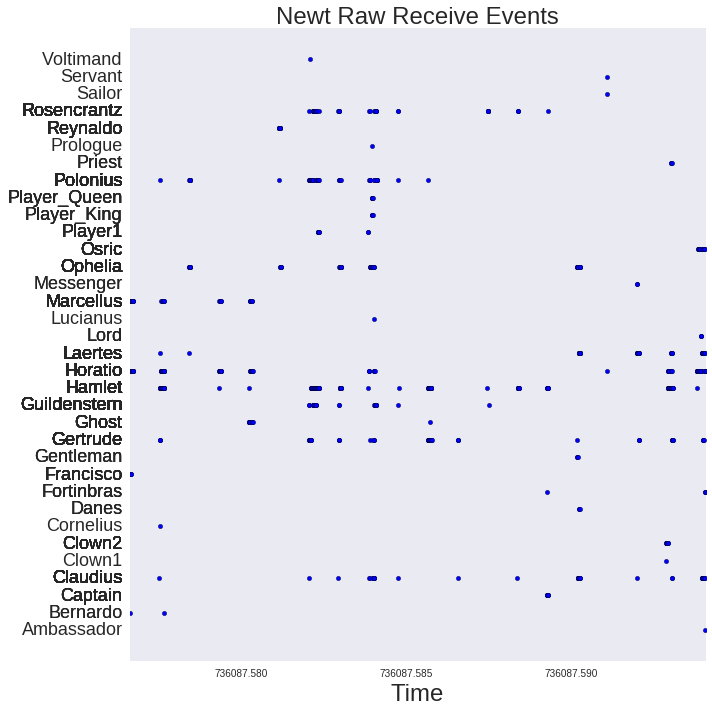

In [61]:
Figure = plt.figure(figsize=(10,10))
data2=zip(*data)
import matplotlib.dates as dates
#new_x = dates.datestr2num(data2)
newx = dates.date2num(data2[0])
newy = [int(y.split('.')[3]) for y in data2[1]]
yticks = [addr_to_actor[y] for y in data2[1]]
plt.yticks(newy,yticks,fontsize=18)
plt.scatter(newx,newy,)
plt.grid('off')
plt.title('Newt Raw Receive Events',fontsize=24)
plt.xlabel('Time',fontsize=24)
plt.xlim(min(newx),max(newx))
plt.show()
